## 0.0 Imports and Helper Functions

### 0.1 Imports

In [183]:
# Data Manipulation
# -----------------------------------
import pandas as pd
import numpy as np

# Visualizations
#------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display      import Image
from IPython.core.display import HTML 

# Hypothesis Testing
# -----------------------------------
from scipy import stats as st

# Data preparation
# -----------------------------------
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Machine Learning Models
#------------------------------------
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn import feature_selection


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### 0.2 Helper Functions

In [15]:
def jupyter_settings():
    %matplotlib inline
    
    sns.set(font_scale=1.6)
    
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
jupyter_settings()

In [126]:
def eval_metrics(model_name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return pd.DataFrame({'R2': np.round(r2, 3),
                         'RMSE': np.round(rmse, 3)}, 
                        index=[model_name])

## 1.0 Data Description

### 1.1 Load Dataset

In [5]:
url = 'https://gist.githubusercontent.com/meperezcuello/82a9f1c1c473d6585e750ad2e3c05a41/raw/d42d226d0dd64e7f5395a0eec1b9190a10edbc03/Medical_Cost.csv'
df = pd.read_csv(url)

In [16]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [17]:
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


### 1.2 Data Dimensions

In [20]:
df.shape

(1338, 7)

### 1.3 Data Types and Structure

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### 1.4 Check NA

In [22]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### 1.5 Check Duplicates

In [24]:
df.duplicated().sum()

1

In [25]:
df[df.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [26]:
df.drop_duplicates(inplace=True)

In [29]:
df.shape

(1337, 7)

## 2.0 EDA

### 2.1 Univariate Analysis

#### 2.1.1 Categorical Variables

In [10]:
cat_vars = df.select_dtypes(include=object)
describe = cat_vars.describe()
describe

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


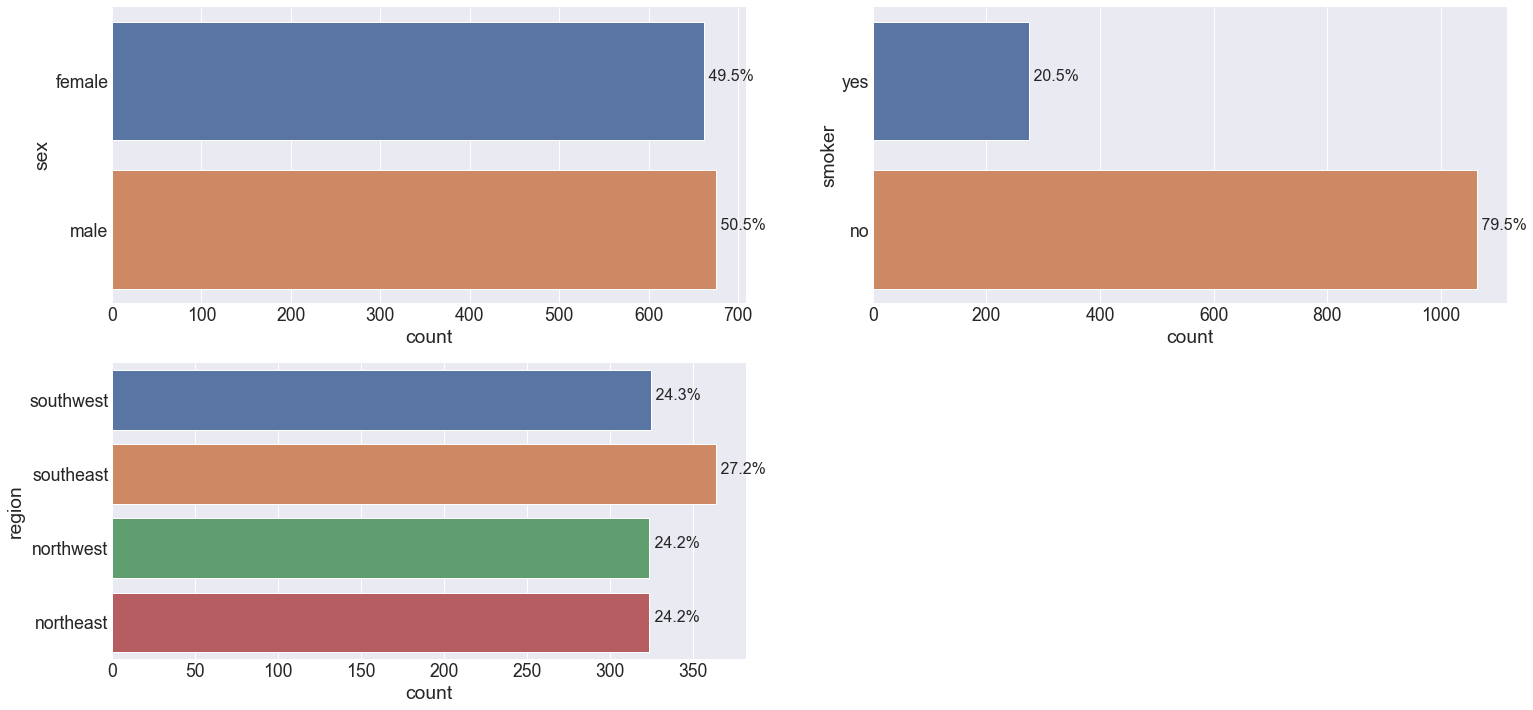

In [389]:
columns = cat_vars
j = 1

for column in columns:
    plt.subplot(2, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.05
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

<b>Summary:</b>
<ul>
    <li><b>Sex:</b> categories in this variable are distributed almost equally. There is 50.5% of <em>males</em> and 49.5% of <em>females</em>;</li>
    <li><b>Smoker:</b> there is much more <em>non-smokers</em> than <em>smokers</em>. 79.5% and 20.5% resp.;</li>
    <li><b>Region:</b> <em>southwest</em>, <em>northwest</em>, <em>northeast</em> is in around 24% of observations each. <em>Southeast</em> is in 27% of observations.</li>
</ul>

#### 2.1.2 Numerical Variables

In [11]:
num_vars = df.select_dtypes(exclude=object)

describe = num_vars.describe().T
describe['skew'] = num_vars.skew().tolist()
describe['kurtosis'] = num_vars.kurtosis().tolist()
describe

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000,0.055673,-1.245088
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000,0.284047,-0.050732
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000,0.938380,0.202454
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801,1.515880,1.606299


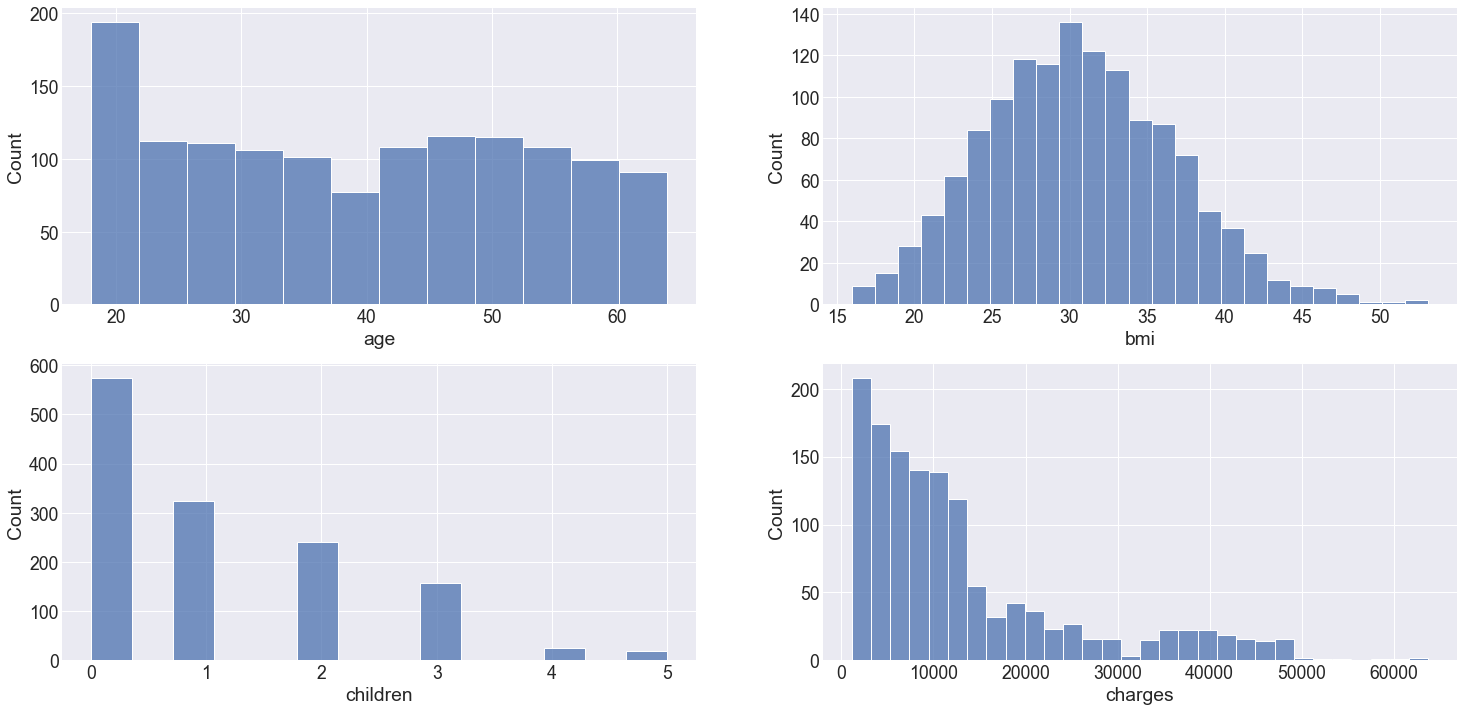

In [16]:
columns = num_vars.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 2, j)
    sns.histplot(num_vars[column]);
    
    j += 1

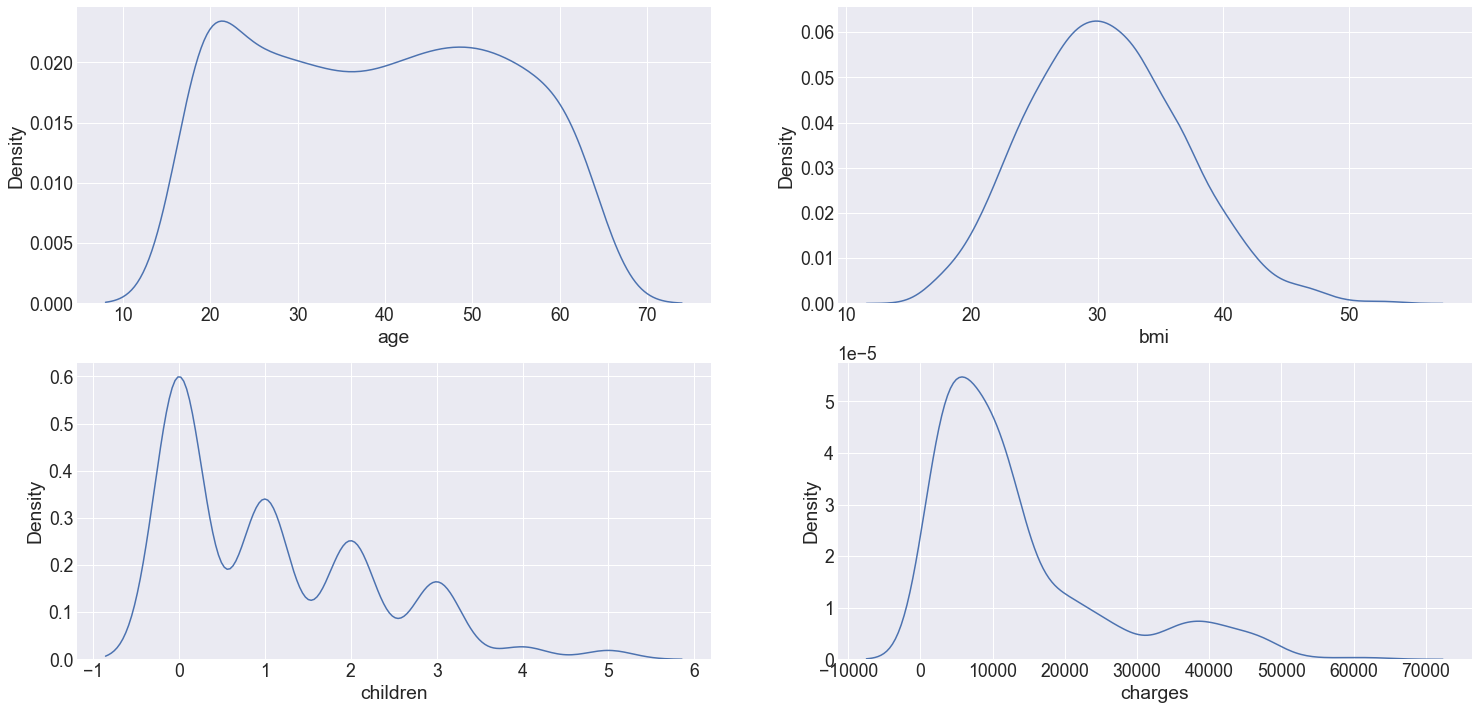

In [18]:
j = 1
for column in columns:
    plt.subplot(2, 2, j)
    sns.kdeplot(num_vars[column]);
    
    j += 1

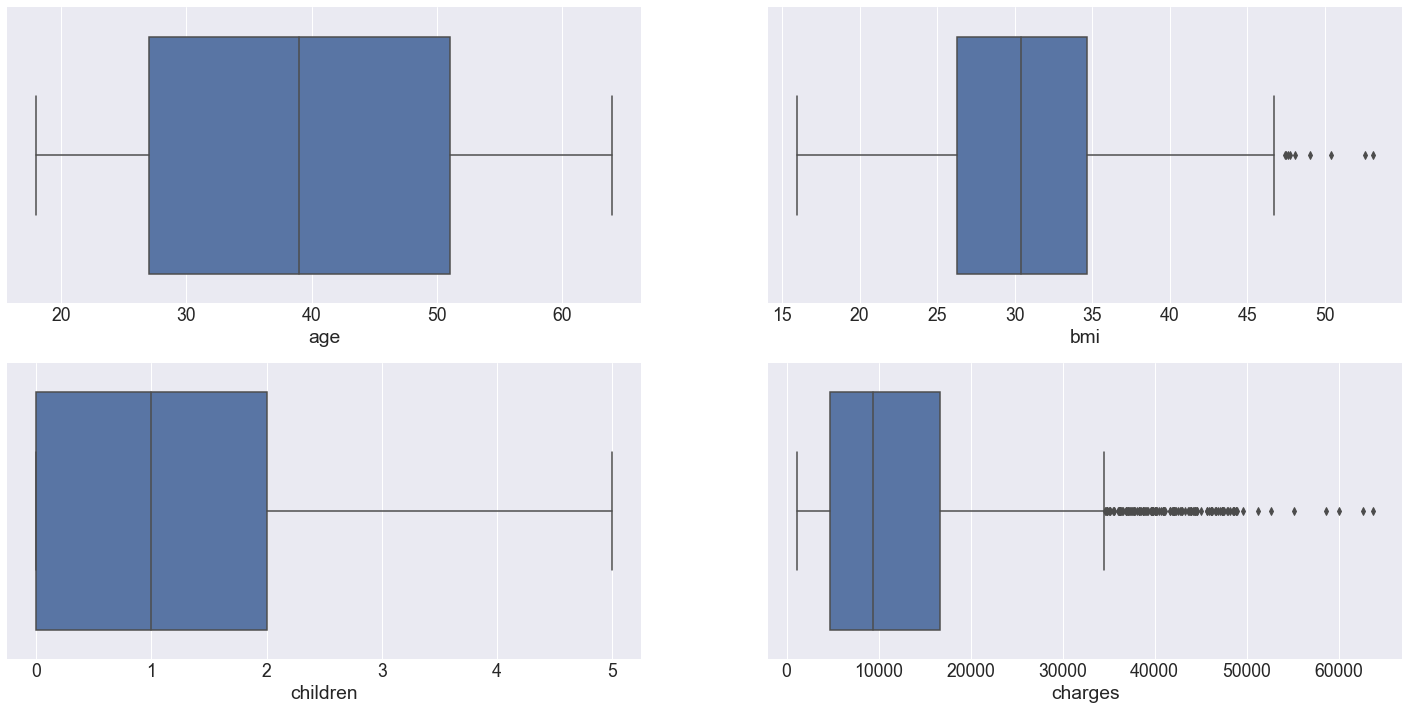

In [21]:
j = 1
for column in columns:
    plt.subplot(2, 2, j)
    sns.boxplot(x = num_vars[column]);
    
    j += 1

##### 2.1.2.1 Age

In [217]:
df.age.value_counts().head()

18    69
19    67
50    29
51    29
47    29
Name: age, dtype: int64

In [218]:
df.age.value_counts().tail()

61    23
60    23
63    23
62    23
64    22
Name: age, dtype: int64

<ul>
    <li>There is a little positive skew (0.05), which means that there are more values on the left side of the distribution.</li>
    <li>There is twice more pations of age 18 and 19 than pations of any other age.</li>
    <li>Bucketing could be considered later on to improve the balance of the categories as it may be easier for the model to make accurate predictions.</li>
</ul>

##### 2.1.2.2 Children

In [245]:
df.children.value_counts()/len(df)

0    0.428571
1    0.242334
2    0.179506
3    0.117427
4    0.018699
5    0.013463
Name: children, dtype: float64

<ul>
    <li>Most of the obserations have 1 child or no children at all.</li>
</ul>

##### 2.1.2.3 BMI

##### Test of normality

<ul>
    <li><b>H<sub>0</sub></b> : Variable follows a normal distribution,</li>
    <li><b>H<sub>1</sub></b> : Variable does not follow a normal distribution</li>
</ul>

In [22]:
bmi_mean = df.bmi.mean()
bmi_std = df.bmi.std()

stat, p = st.kstest(df.bmi, 'norm', args=(bmi_mean, bmi_std))

if p < 0.05:
    print("KS test statistic: {}\np-value: {}\nThe BMI variable is not normally distributed.".format(stat, p))
else:
    print("KS test statistic: {}\np-value: {}\nThe BMI variable is normally distributed.".format(stat, p))

KS test statistic: 0.026099881197044872
p-value: 0.3162798242838005
The BMI variable is normally distributed.


<ul>
    <li>Histogram shows that the BMI variable tends to follow a bell-shaped curve, which could be a sign of a normal distribution,</li>
    <li>Kolmogorov-Smirnov test approved the null hypothesis with the significance level of 0.05,</li>
    <li>Boxplot shows a number of outliers beyond the upper whisker. However, those values are probably not errors, since BMI depicts weight levels, and BMI > 35 stands for 'extremely obese'.</li>
</ul>

##### 2.1.2.4 Charges

<ul>
    <li>The data appears to be positively skewed, with most of the observations clustered around the lower end of the distribution and a long tail of higher values,</li>
    <li>There is a big number of outliers beyond the upper whisker,</li>
    <li>The density plot shows that a distribution is bimodal, which could be a sign of subpopulations.</li>
</ul>

### 2.2 Bivariate Analysis

#### 2.2.1 Charges vs Smoker

In [30]:
charges_of_smokers = df[df.smoker == 'yes'].charges
describe = charges_of_smokers.describe()
describe['skew'] = charges_of_smokers.skew()
describe['kurtosis'] = charges_of_smokers.kurtosis()
describe

count         274.000000
mean        32050.231832
std         11541.547176
min         12829.455100
25%         20826.244213
50%         34456.348450
75%         41019.207275
max         63770.428010
skew            0.128217
kurtosis       -1.036534
Name: charges, dtype: float64

In [34]:
charges_of_nonsmokers = df[df.smoker == 'no'].charges
describe = charges_of_nonsmokers.describe()
describe['skew'] = charges_of_nonsmokers.skew()
describe['kurtosis'] = charges_of_nonsmokers.kurtosis()
describe

count        1064.000000
mean         8434.268298
std          5993.781819
min          1121.873900
25%          3986.438700
50%          7345.405300
75%         11362.887050
max         36910.608030
skew            1.538120
kurtosis        3.149220
Name: charges, dtype: float64

<AxesSubplot:xlabel='charges', ylabel='Density'>

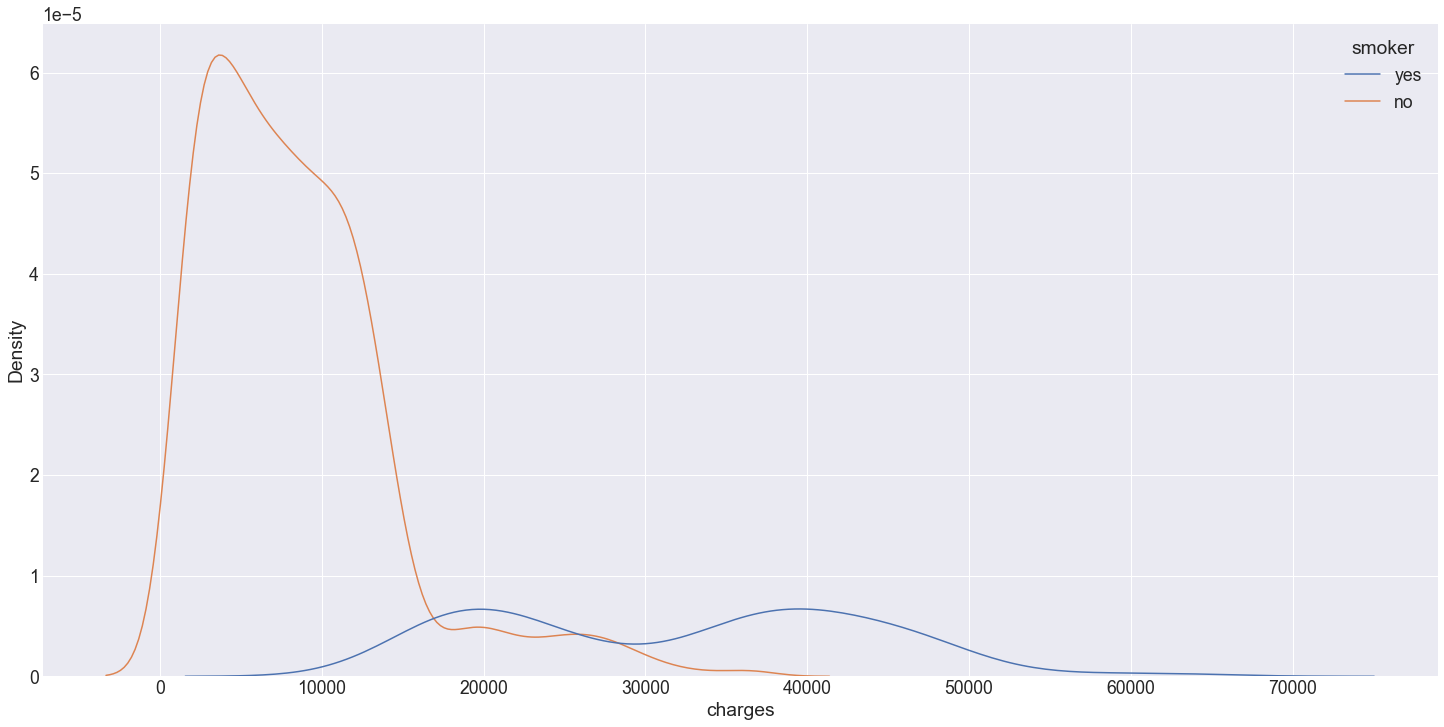

In [33]:
sns.kdeplot(data = df, x = 'charges', hue = 'smoker')

<AxesSubplot:xlabel='charges', ylabel='smoker'>

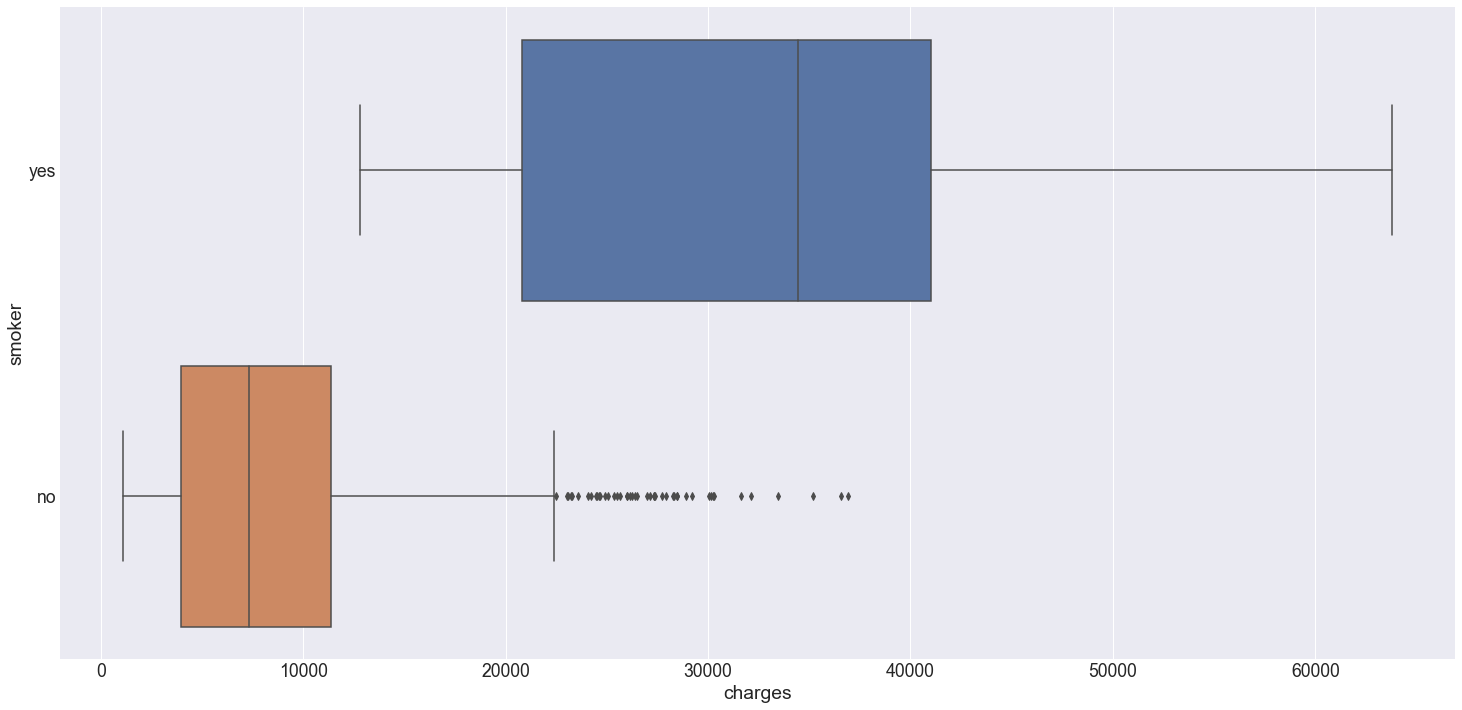

In [28]:
sns.boxplot(x = df.charges, y = df.smoker)

<ul>
    <li>The mean of charges of smokers is 32050.23, where the mean of charges of non-smokers is 8440.66</li>
    <li>The density plot suggests that there is a significant difference between the charges of smokers and non-smokers, with smokers having higher charges and greater variability in charges than non-smokers.</li>
    <li>Boxpot suggests that there is a significant number of outliers in charges of non-smokers, possibly due to some serious conditions.  </li>
</ul>

#### 2.2.2 Charges vs Sex

<AxesSubplot:xlabel='charges', ylabel='Density'>

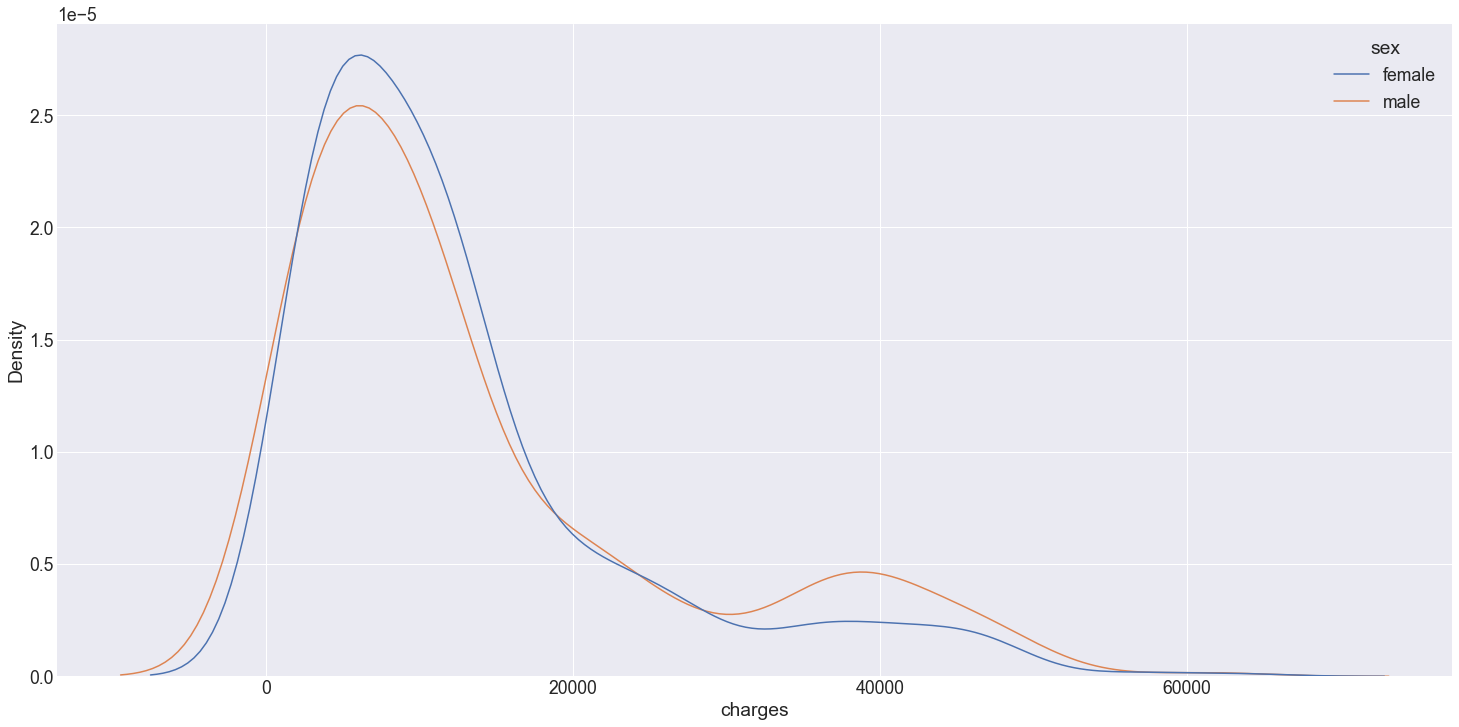

In [37]:
sns.kdeplot(data = df, x = 'charges', hue = 'sex')

<AxesSubplot:xlabel='charges', ylabel='sex'>

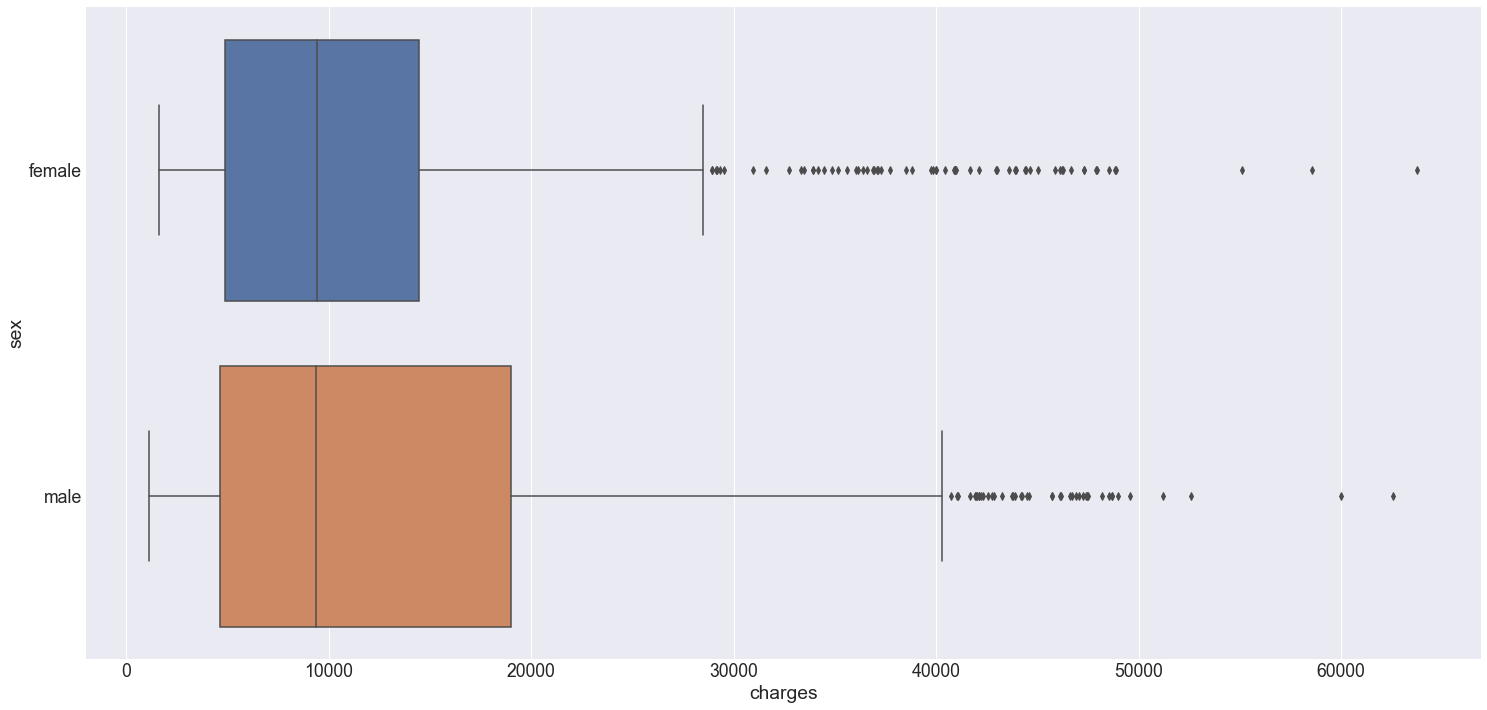

In [38]:
sns.boxplot(x = df.charges, y = df.sex)

There is no apparent difference between charges of males and females.

#### 2.2.2 Charges vs Region

<AxesSubplot:xlabel='charges', ylabel='Density'>

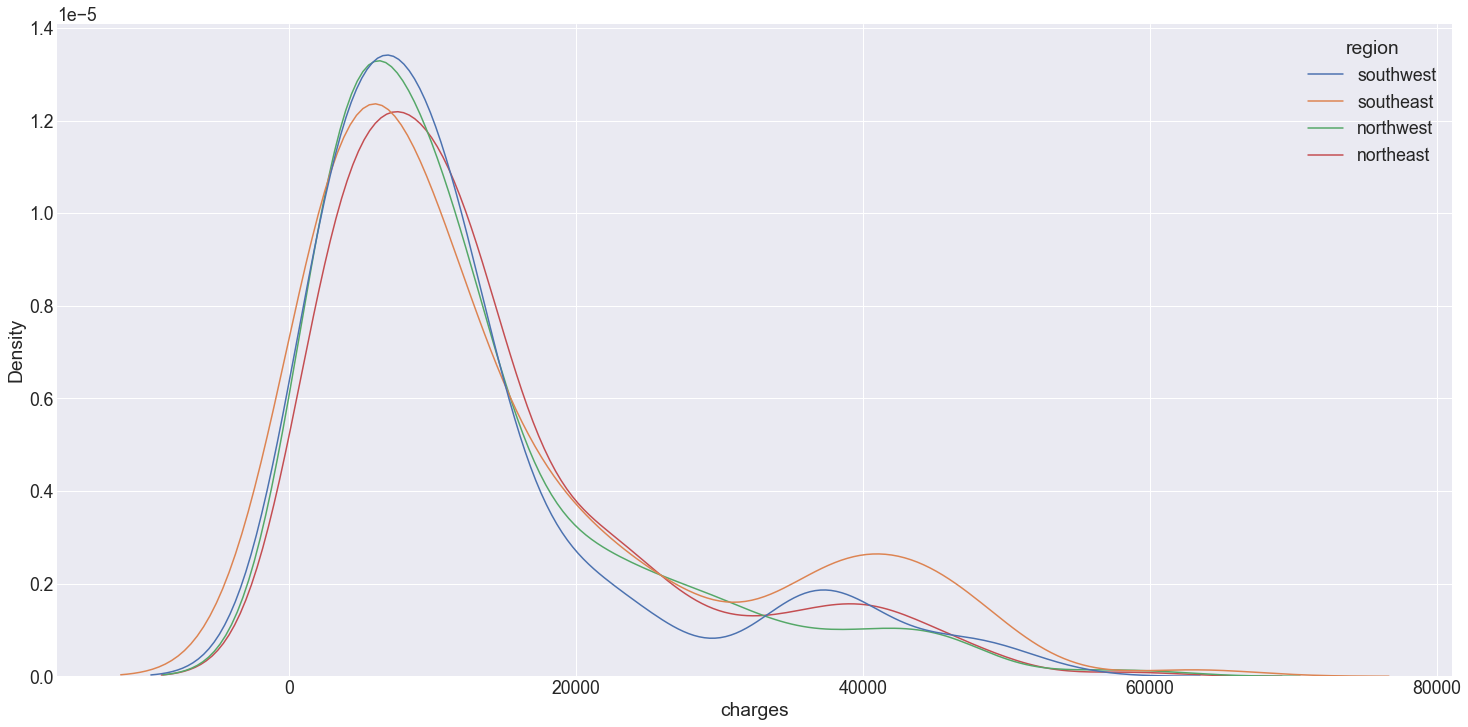

In [39]:
sns.kdeplot(data = df, x = 'charges', hue = 'region')

<AxesSubplot:xlabel='charges', ylabel='region'>

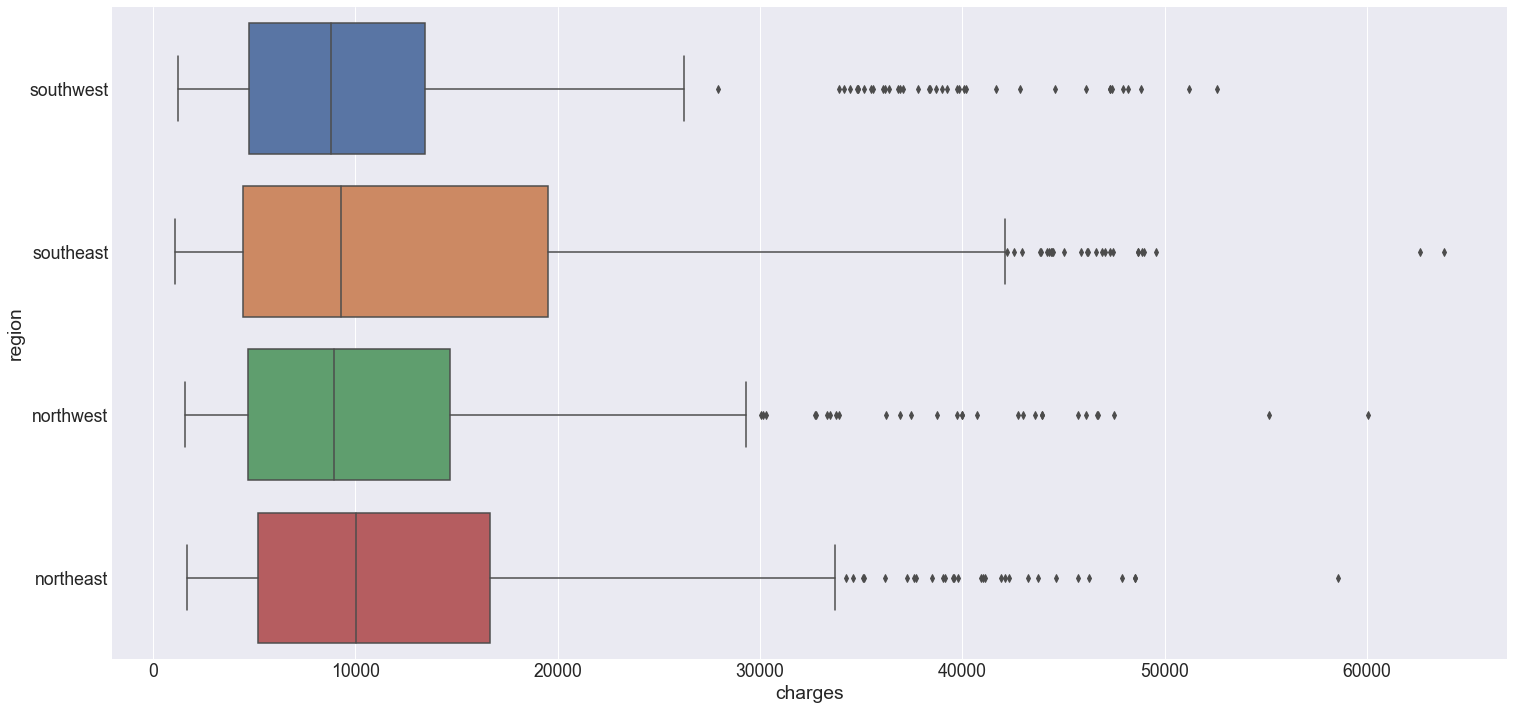

In [40]:
sns.boxplot(x = df.charges, y = df.region)

#### 2.2.3 Charges vs Children

<AxesSubplot:xlabel='children', ylabel='charges'>

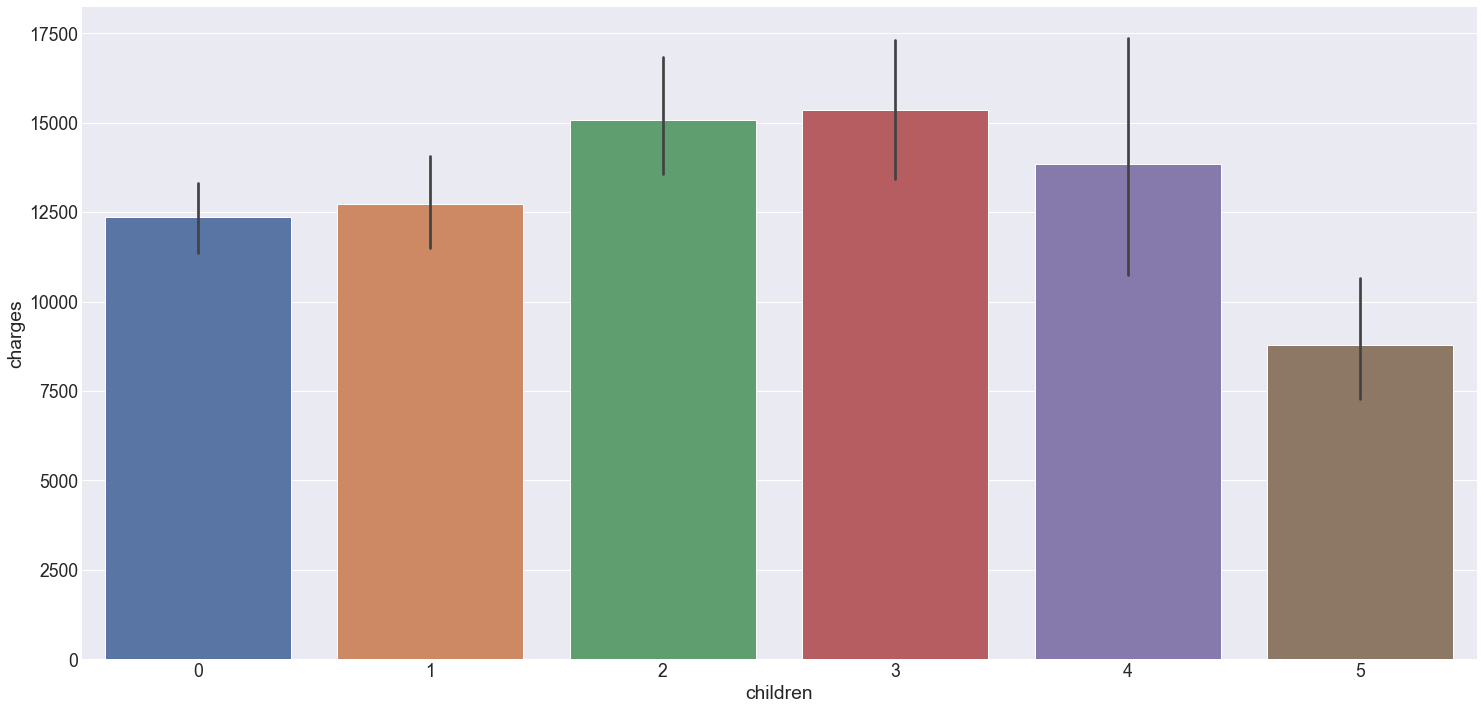

In [44]:
sns.barplot(data=df, x='children', y='charges')

<ul>
    <li>People with 2, 3 or 4 children pay more on average,</li>
    <li>People with 5 children pay less relatively to people with smaller number of children.</li>
</ul>

#### 2.2.4 Charges vs Age and Smoker

<AxesSubplot:xlabel='age', ylabel='charges'>

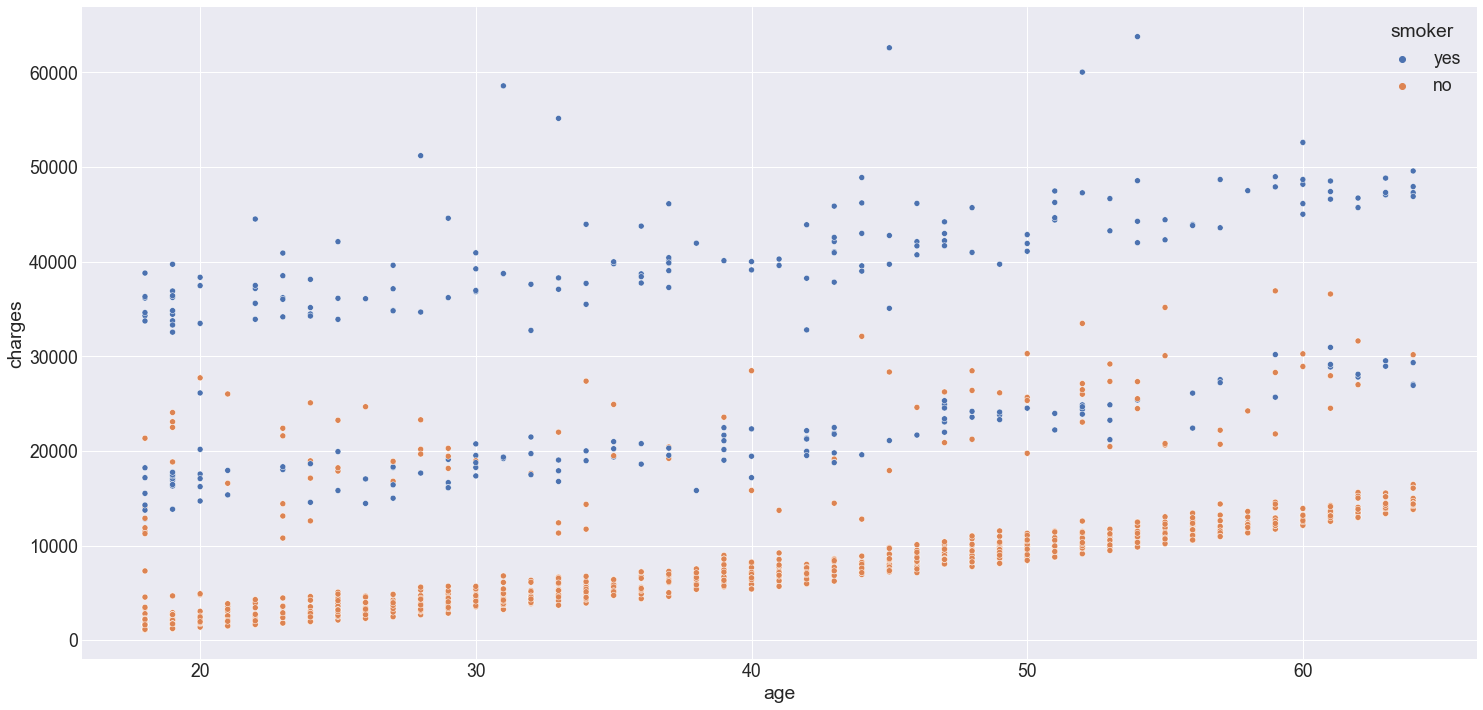

In [50]:
sns.scatterplot(data=df, x='age', y='charges', hue='smoker')

<ul>
    <li>The amount of charges increases with age,</li>
    <li>There is 3 distinct clusters of points,</li>
    <li>The middle cluster is mixed with smokers and non-smokers. Most probably these are two distinct groups of smokers without medical conditions and non-smokers with medical conditions,</li>
    <li>The relationship between age and charges seems linear.</li>
</ul>

#### 2.2.5 Charges vs BMI and Smoker

<AxesSubplot:xlabel='bmi', ylabel='charges'>

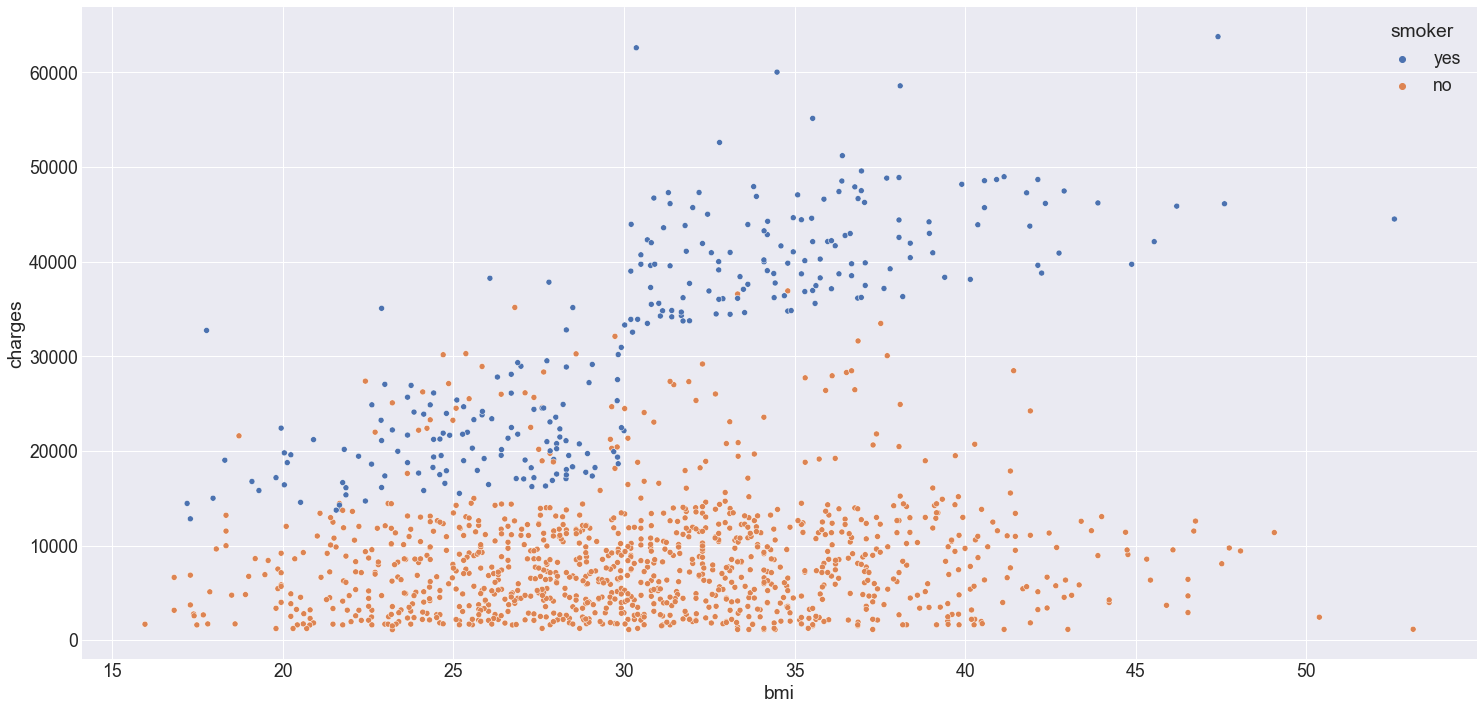

In [51]:
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker')

<ul>
    <li>It seems that BMI stand-alone does not affect the amount of charges. However with positive smoking status and BMI > 30, the amount of charges is increasing significantly.</li>
</ul>

#### 2.2.6 Correlation analysis

Text(0.5, 1.0, 'Correlation Matrix')

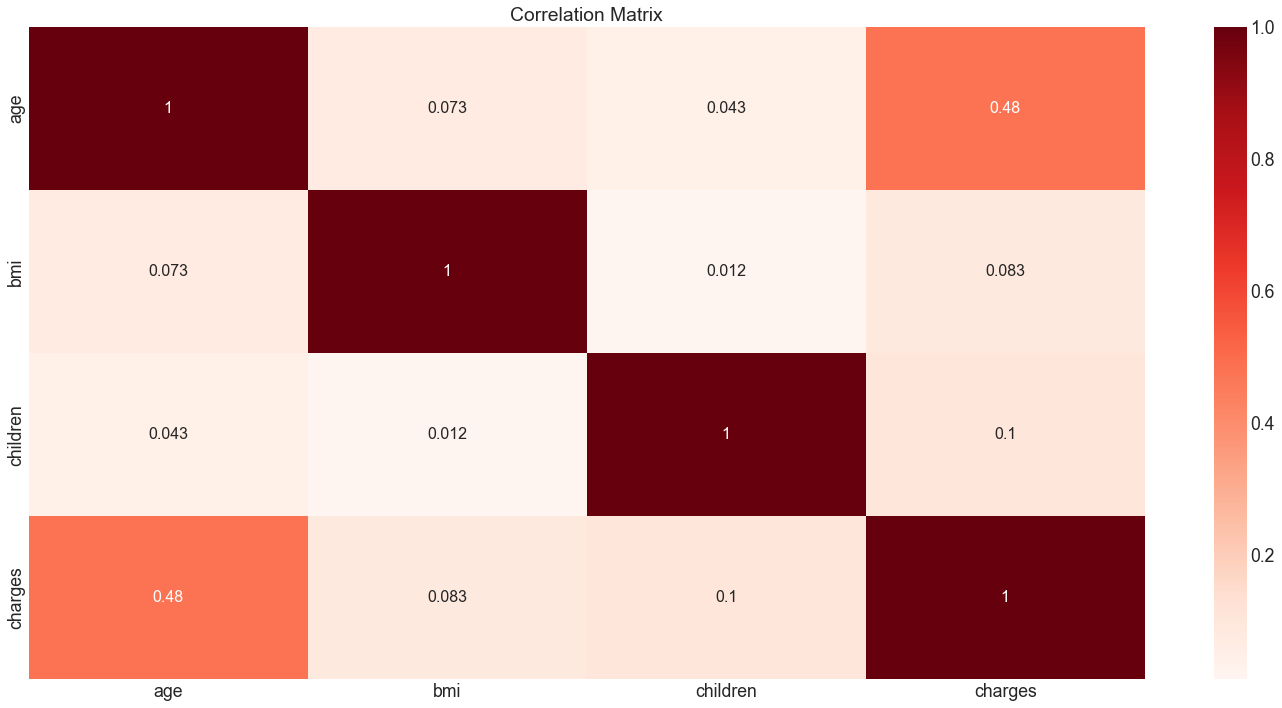

In [189]:
sns.heatmap(df.corr(method='kendall'), cmap='Reds', annot=True)
plt.title('Correlation Matrix')

## 3.0 Data Preparation

### 3.1 Train-Test Split

In [179]:
x_bin = ['age', 'bmi', 'children', 'smoker', 'sex', 'region']

X = df[x_bin]
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### 3.2 Encoding categorical variables

In [64]:
# smoker_codes = {'no': 0, 'yes': 1}
# df['smoker_code'] = df.smoker.map(smoker_codes)

# sex_codes = {'female' : 0, 'male' : 1}
# df['sex_code'] = df.sex.map(sex_codes)

# region_codes = {'southwest' : 0, 'southeast' : 1, 'northwest' : 2, 'northeast' : 3}
# df['region_code'] = df.region.map(region_codes)

In [180]:
cat_vars = ['smoker', 'sex', 'region']

encoder = OneHotEncoder(cols=cat_vars, use_cat_names=True)

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

### 3.3 Rescaling

In [181]:
num_vars = ['age', 'bmi', 'children']

scaler = MinMaxScaler()

X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

In [182]:
X_train.head()

,age,bmi,children,smoker_no,smoker_yes,sex_female,sex_male,region_northeast,region_northwest,region_southwest,region_southeast
1328,0.108696,0.222357,0.4,1,0,1,0,1,0,0,0
1015,0.891304,0.255582,0.0,1,0,0,1,0,1,0,0
861,0.434783,0.323917,0.6,1,0,1,0,0,0,1,0
469,0.000000,0.218725,0.2,1,0,1,0,0,0,0,1
981,0.347826,0.145682,0.0,1,0,0,1,1,0,0,0


## 4.0 Machine Learning Modeling

### 4.1 Baseline

In [176]:
# Test options and evaluation metric
num_folds = 5
scoring = 'neg_root_mean_squared_error'

In [192]:
# Spot-Check Algorithms
models = []
models.append(('DR', DummyRegressor()))
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))

In [204]:
# evaluate each model
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "{}: {:.3f} ({:.3f})".format(name, cv_results.mean(), cv_results.std())
    print(msg)

DR: -12212.301 (517.795)
LR: -6135.737 (484.319)
LASSO: -6132.674 (482.334)
EN: -9243.737 (491.716)
DTR: -7025.057 (370.606)
KNN: -6141.765 (625.674)
SVR: -12783.205 (705.338)


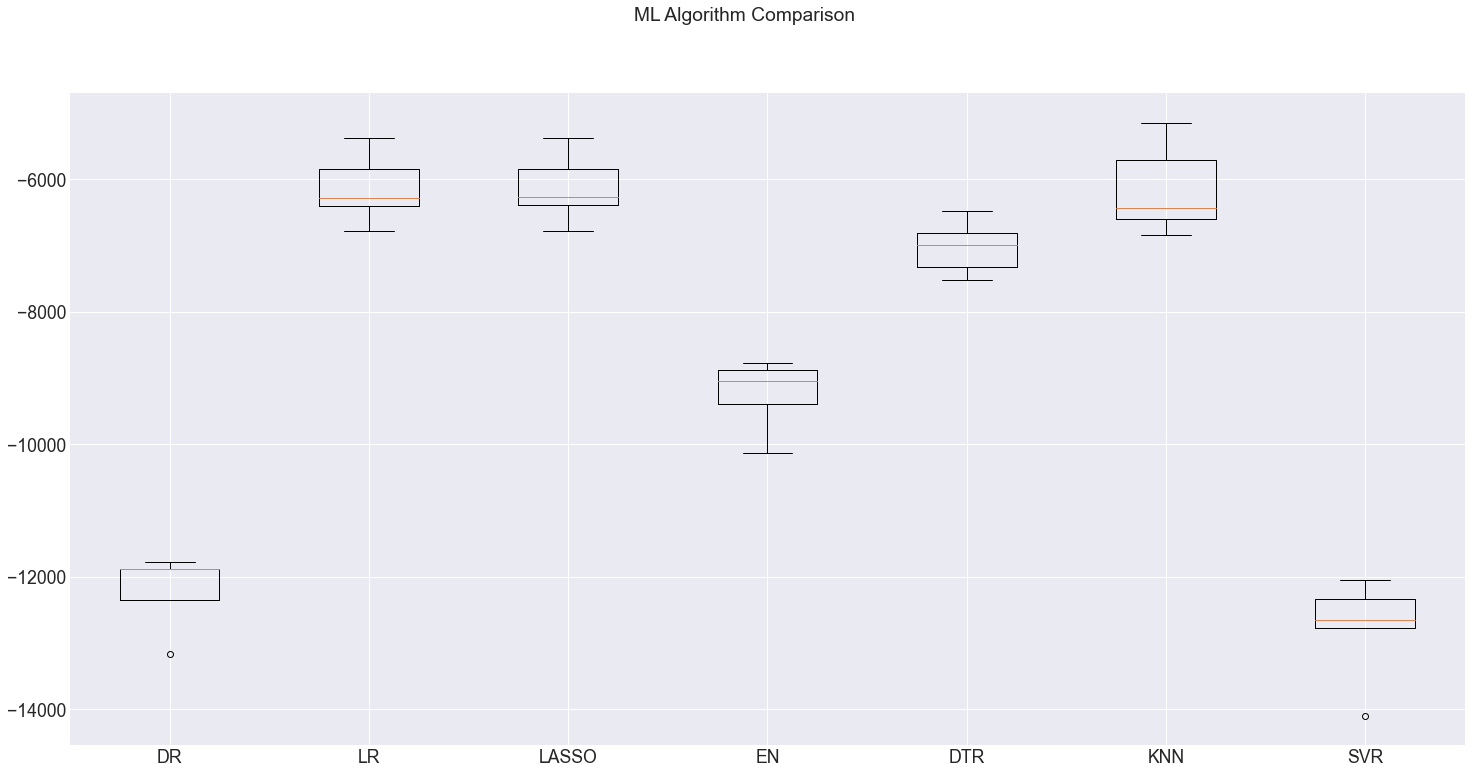

In [209]:
fig = plt.figure()
fig.suptitle('ML Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### 4.2 Ensemble Methods

In [210]:
ensembles = []
ensembles.append(('RFR', RandomForestRegressor()))
ensembles.append(('GBR', GradientBoostingRegressor()))
ensembles.append(('ETR', ExtraTreesRegressor()))
ensembles.append(('ABR', AdaBoostRegressor()))

In [211]:
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "{}: {:.3f} ({:.3f})".format(name, cv_results.mean(), cv_results.std())
    print(msg)

RFR: -5008.640 (623.784)
GBR: -4765.449 (734.280)
ETR: -5224.452 (359.572)
ABR: -5176.299 (434.939)


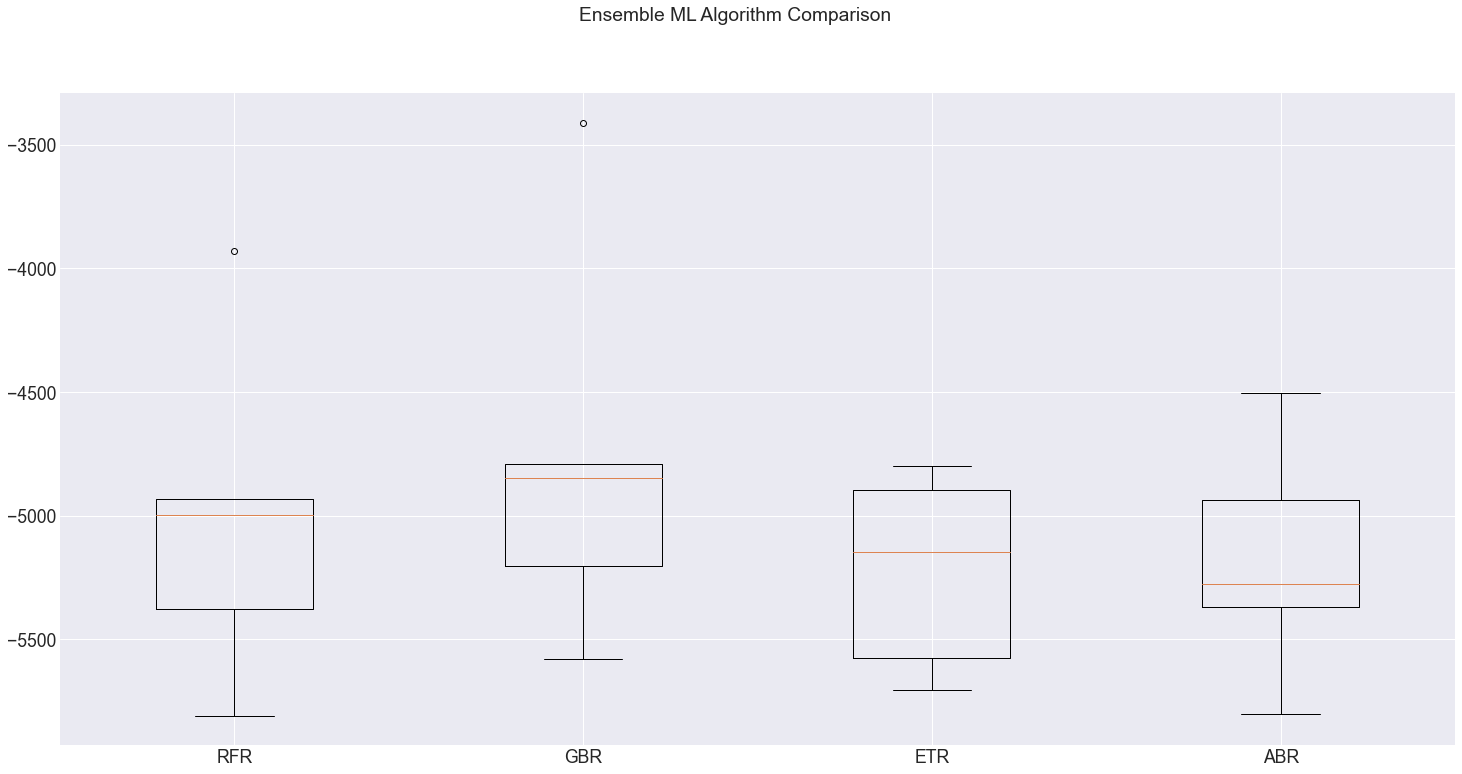

In [212]:
fig = plt.figure()
fig.suptitle('Ensemble ML Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()